# Brain tumor detection and localization

##### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

##### Opening file path

In [2]:
%cd /Users/ada-ihueze/Documents/brain2/Brain_MRI

/Users/ada-ihueze/Documents/brain2/Brain_MRI


##### opening file

In [4]:
brain_file = pd.read_csv('mask.csv')

##### Getting file info

In [5]:
brain_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


##### First 30 rows in the file

In [6]:
brain_file.head(30)

patient_id                                         image_path  \
0   TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1   TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2   TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3   TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4   TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
5   TCGA_CS_5395_19981004  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif   
6   TCGA_CS_5395_19981004  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif   
7   TCGA_CS_5395_19981004  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif   
8   TCGA_CS_5395_19981004  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif   
9   TCGA_CS_5395_19981004  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif   
10  TCGA_CS_5395_19981004  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif   
11  TCGA_CS_5395_19981004  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1.tif   
12  TCGA_CS_5395_19981004  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1.tif   
13  TCGA_CS_5395_19981004  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1.tif   
14  TCGA_CS_5395_19981004  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1.tif   
15  TCGA_CS_5395_19981004  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1.tif   
16  TCGA_CS_5395_19981004  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1.tif   
17  TCGA_CS_5395_19981004  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1.tif   
18  TCGA_CS_5395_19981004  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1.tif   
19  TCGA_CS_5395_19981004  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1.tif   
20  TCGA_CS_4944_20010208  TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1.tif   
21  TCGA_CS_4944_20010208  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif   
22  TCGA_CS_4944_20010208  TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif   
23  TCGA_CS_4944_20010208  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif   
24  TCGA_CS_4944_20010208  TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif   
25  TCGA_CS_4944_20010208  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif   
26  TCGA_CS_4944_20010208  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1.tif   
27  TCGA_CS_4944_20010208  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif   
28  TCGA_CS_4944_20010208  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1.tif   
29  TCGA_CS_4944_20010208  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif   

                                            mask_path  mask  
0   TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1   TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2   TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3   TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4   TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
5   TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...     0  
6   TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...     0  
7   TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...     0  
8   TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...     0  
9   TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...     0  
10  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1_...     0  
11  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1_...     0  
12  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1_...     0  
13  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1_...     0  
14  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1_...     0  
15  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1_...     0  
16  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1_...     0  
17  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1_...     0  
18  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1_...     0  
19  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1_...     0  
20  TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1_...     0  
21  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1_...     0  
22  TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1_...     0  
23  TCGA_DU_6399_19830416/TCGA_DU_6399_1983041

##### File summary

In [8]:
brain_file

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

##### Checking file type

In [9]:
brain_file['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

# Data Visualization

##### Visualizing image

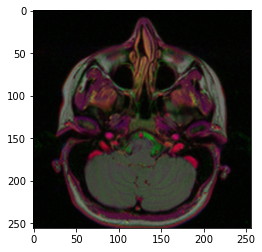

In [11]:
plt.imshow(cv2.imread(brain_file.image_path[723]))

##### maximum

In [12]:
cv2.imread(brain_file.mask_path[623]).max()

255

##### Minimum

In [13]:
cv2.imread(brain_file.mask_path[723]).min()

0

##### Visualization of six random files

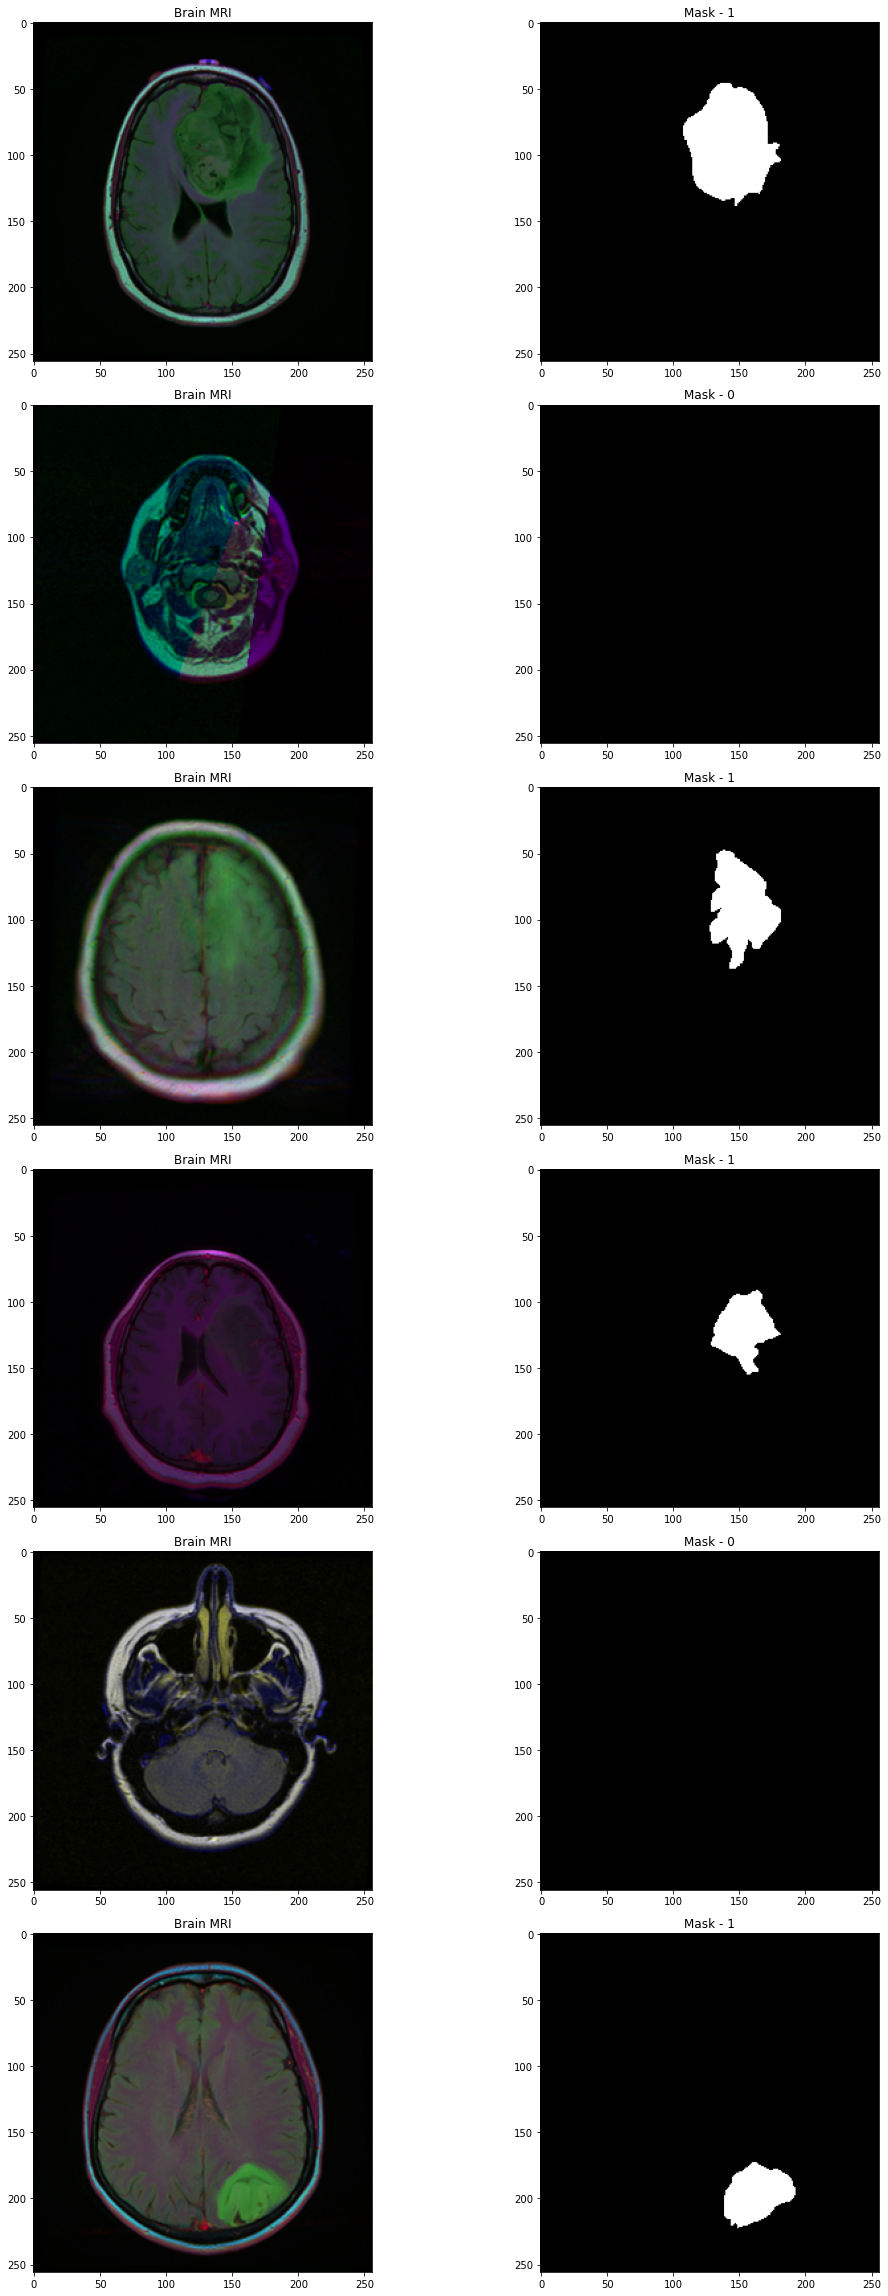

In [14]:
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_file)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_file.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_file['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_file.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

##### Visualizing random twelve files with the location of masks in the brain

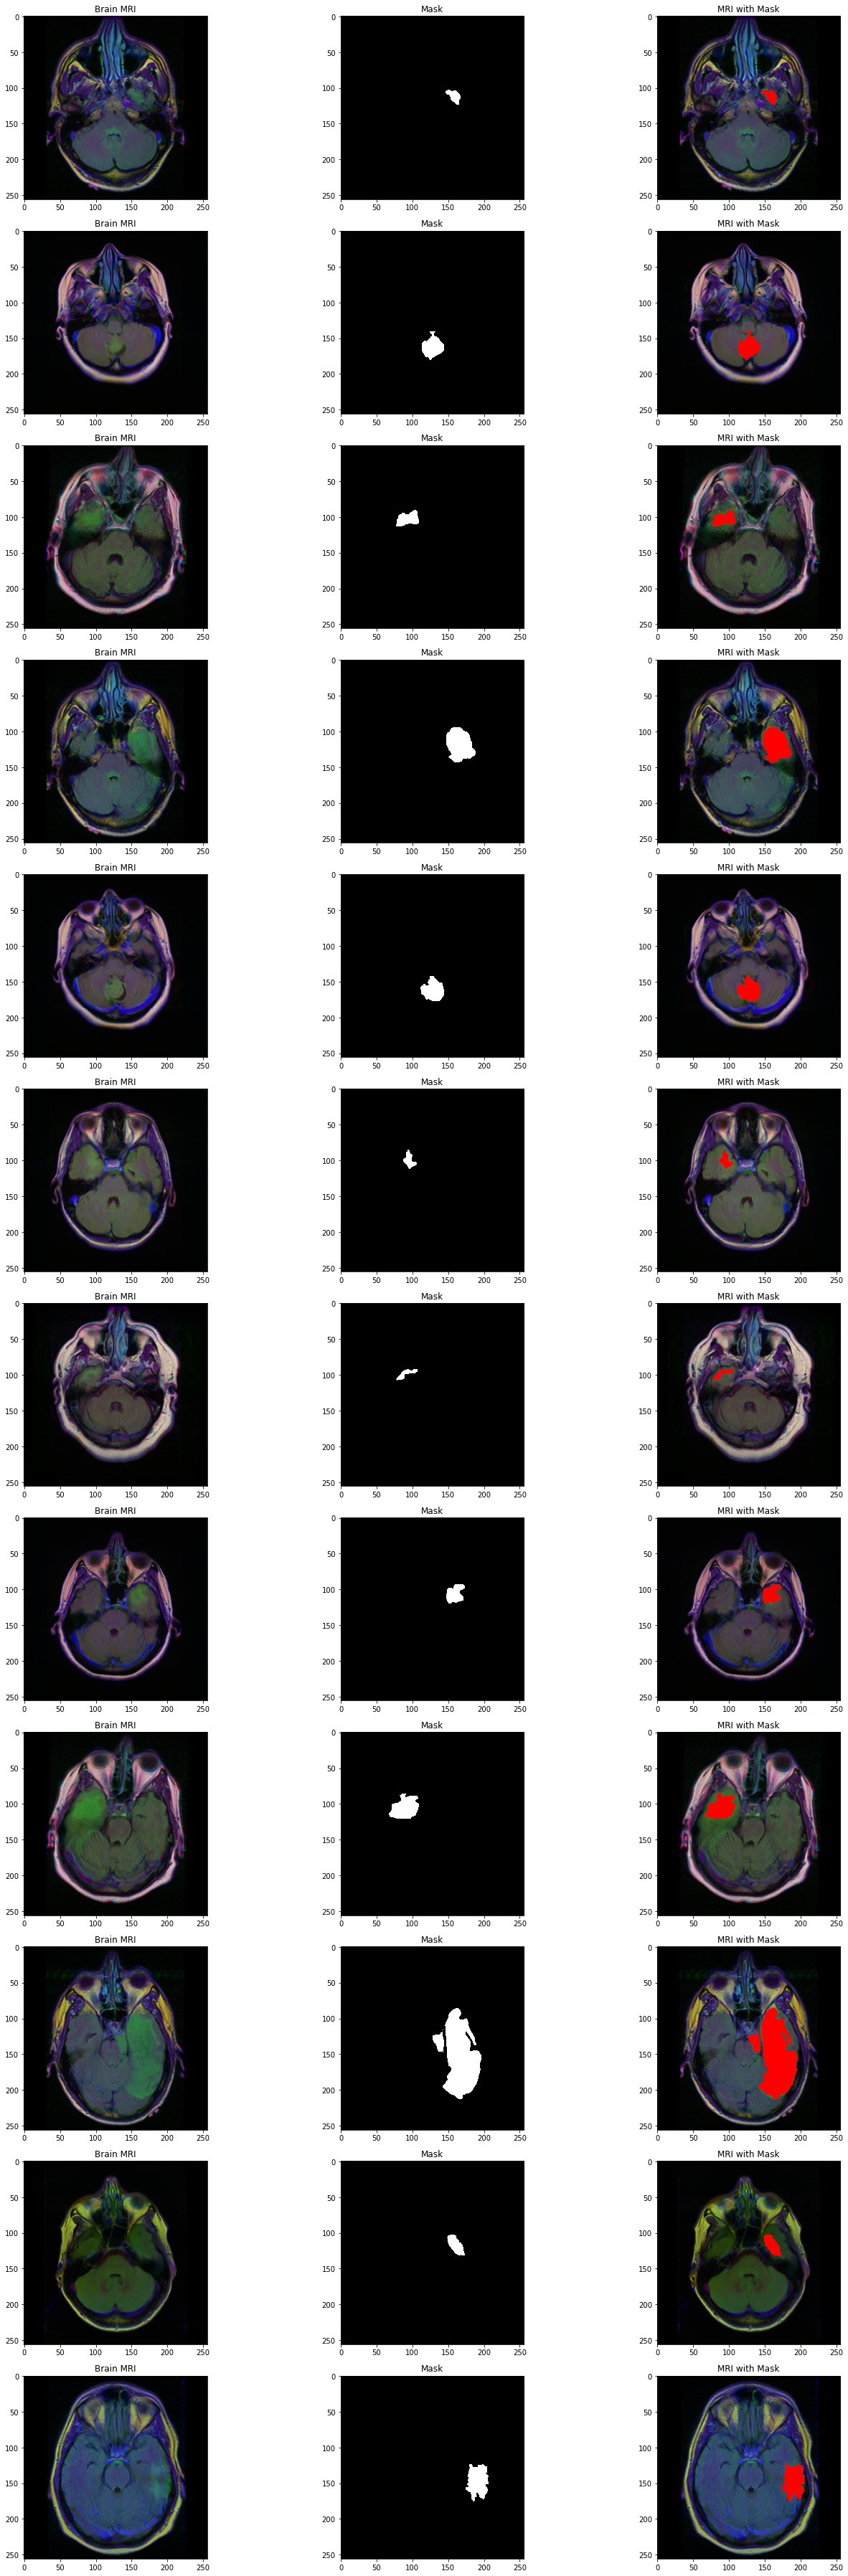

In [16]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_file)):
  if brain_file['mask'][i] ==1 and count <12:
    img = io.imread(brain_file.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_file.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

##### total number of items in file

In [17]:
brain_file_train = brain_file.drop(columns = ['patient_id'])
brain_file_train.shape

(3929, 3)

##### Converting image to string

In [18]:
brain_file_train['mask'] = brain_file_train['mask'].apply(lambda x: str(x))

##### Splitting the data

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_file_train, test_size = 0.15)

##### Image data generation

In [20]:
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

##### Creating subset data generation

In [21]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory= './',
    x_col='image_path',
    y_col='mask',
    subset="training",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory= './',
    x_col='image_path',
    y_col='mask',
    subset="validation",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory= './',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(256,256))


Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


##### Creating the base model

In [22]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

##### Base model summary

In [23]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

##### Freezing the model weights

In [24]:
for layer in basemodel.layers:
  layers.trainable = False

##### Adding classification network to the base model

In [25]:
brainmodel = basemodel.output
brainmodel = AveragePooling2D(pool_size = (4,4))(brainmodel)
brainmodel = Flatten(name= 'flatten')(brainmodel)
brainmodel = Dense(256, activation = "relu")(brainmodel)
brainmodel = Dropout(0.3)(brainmodel)#
brainmodel = Dense(256, activation = "relu")(brainmodel)
brainmodel = Dropout(0.3)(brainmodel)
brainmodel = Dense(2, activation = 'softmax')(brainmodel)

model = Model(inputs = basemodel.input, outputs = brainmodel)

##### Model summary

In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

##### Model compilation

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

##### Use of early stopping and checkpoints

In [28]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="brain-classifier-weights.hdf5", verbose=1, save_best_only=True)

##### Training the model

In [29]:
history = model.fit(
    train_generator, 
    steps_per_epoch= train_generator.n // 16, 
    epochs = 25, 
    validation_data= valid_generator, 
    validation_steps= valid_generator.n // 16, 
    callbacks=[checkpointer, earlystopping])

Epoch 1/25
177/177 [==============================] - ETA: 0s - loss: 0.8780 - accuracy: 0.7248 
Epoch 00001: val_loss improved from inf to 0.64978, saving model to brain-classifier-weights.hdf5
177/177 [==============================] - 3770s 21s/step - loss: 0.8780 - accuracy: 0.7248 - val_loss: 0.6498 - val_accuracy: 0.6472
Epoch 2/25
177/177 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8151 
Epoch 00002: val_loss did not improve from 0.64978
177/177 [==============================] - 4051s 23s/step - loss: 0.4077 - accuracy: 0.8151 - val_loss: 0.8532 - val_accuracy: 0.6452
Epoch 3/25
177/177 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.8548 
Epoch 00003: val_loss did not improve from 0.64978
177/177 [==============================] - 5946s 34s/step - loss: 0.3437 - accuracy: 0.8548 - val_loss: 0.6747 - val_accuracy: 0.6472
Epoch 4/25
177/177 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8583 
Epoch 0000

## Making predictions

In [30]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 145s 4s/step


In [31]:
test_predict.shape

(576, 2)

In [32]:
test_predict

array([[4.99613285e-02, 9.50038671e-01],
       [1.15557946e-26, 1.00000000e+00],
       [9.99147177e-01, 8.52828671e-04],
       ...,
       [9.99968410e-01, 3.16406476e-05],
       [3.56613200e-05, 9.99964356e-01],
       [8.64295721e-01, 1.35704279e-01]], dtype=float32)

##### Getting the prediction class from the model

In [33]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [34]:
predict

array(['1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0',
       '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0',
       '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0',
       '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1',
       '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1',
       '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1',
       '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0',
       '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1

In [35]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

##### Getting model accuracy

In [36]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9461805555555556

##### Saving the model

In [37]:
model_json = model.to_json()
with open("brain-classifier-model.json","w") as json_file:
  json_file.write(model_json)

##### Visualizing confusion metrics

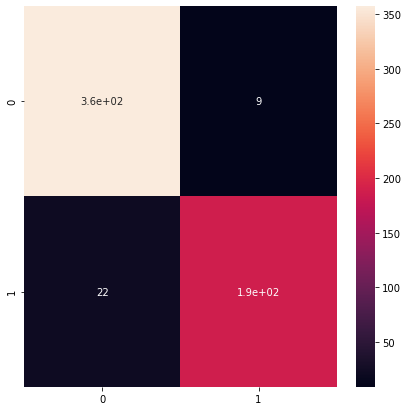

In [38]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

##### Visualizing report

In [39]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       366
           1       0.95      0.90      0.92       210

   micro avg       0.95      0.95      0.95       576
   macro avg       0.95      0.94      0.94       576
weighted avg       0.95      0.95      0.95       576



/Users/ada-ihueze/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


## Building segmentation model

In [40]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_mask = brain_file[brain_file['mask'] == 1]
brain_mask.shape

(1373, 4)

##### Splitting data

In [41]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [42]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

## Custom data generation

In [43]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

##### Building the resnet

In [44]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [45]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [46]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


##### Summary of segmentation model

In [47]:
model_seg.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________

## Loss function

In [48]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

##### Model compilation

In [49]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

##### Use of early stoppage and checkpoints

In [50]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="brain-ResUNet-weights.hdf5", verbose=1, save_best_only=True)

##### Training segmentation model

In [58]:
history = model_seg.fit(
    training_generator, 
    epochs = 10, 
    validation_data = validation_generator, 
    callbacks = [checkpointer, earlystopping])

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.2698 - tversky: 0.8240
Epoch 00001: val_loss did not improve from 0.32421
72/72 [==============================] - 657s 9s/step - loss: 0.2698 - tversky: 0.8240 - val_loss: 0.3257 - val_tversky: 0.7744
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.2387 - tversky: 0.8507
Epoch 00002: val_loss improved from 0.32421 to 0.23830, saving model to brain-ResUNet-weights.hdf5
72/72 [==============================] - 622s 9s/step - loss: 0.2387 - tversky: 0.8507 - val_loss: 0.2383 - val_tversky: 0.8516
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.2285 - tversky: 0.8590
Epoch 00003: val_loss improved from 0.23830 to 0.22302, saving model to brain-ResUNet-weights.hdf5
72/72 [==============================] - 550s 8s/step - loss: 0.2285 - tversky: 0.8590 - val_loss: 0.2230 - val_tversky: 0.8641
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 0.2240 - tversky: 0.

## Predictions

In [59]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [60]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_28...   
1    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17...   
2    TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_34...   
3    TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27...   
4    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_22...   
..                                                 ...   
585  TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_20...   
586  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_19...   
587  TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_11...   
588  TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_5.tif   
589  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_1.tif   

                                        predicted_mask  has_mask  
0    [[[[1.2040475e-06], [6.073756e-07], [1.242024e...         1  
1    [[[[1.0725066e-06], [5.776752e-07], [1.3484846...         1  
2                                              No mask         0  
3                                              No mask         0  
4                                              No mask         0  
..                                                 ...       ...  
585  [[[[9.3191034e-07], [6.0237204e-07], [1.218953...         1  
586                                            No mask         0  
587                                            No mask         0  
588                                            No mask         0  
589                                            No mask         0  

[590 rows x 3 columns]

In [61]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_28...   
1  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17...   
2  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_34...   
3  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27...   
4  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_22...   

                                           mask_path mask  \
0  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_28...    1   
1  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17...    1   
2  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_34...    0   
3  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27...    0   
4  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_22...    1   

                                      predicted_mask  has_mask  
0  [[[[1.2040475e-06], [6.073756e-07], [1.242024e...         1  
1  [[[[1.0725066e-06], [5.776752e-07], [1.3484846...         1  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

##### Visualization

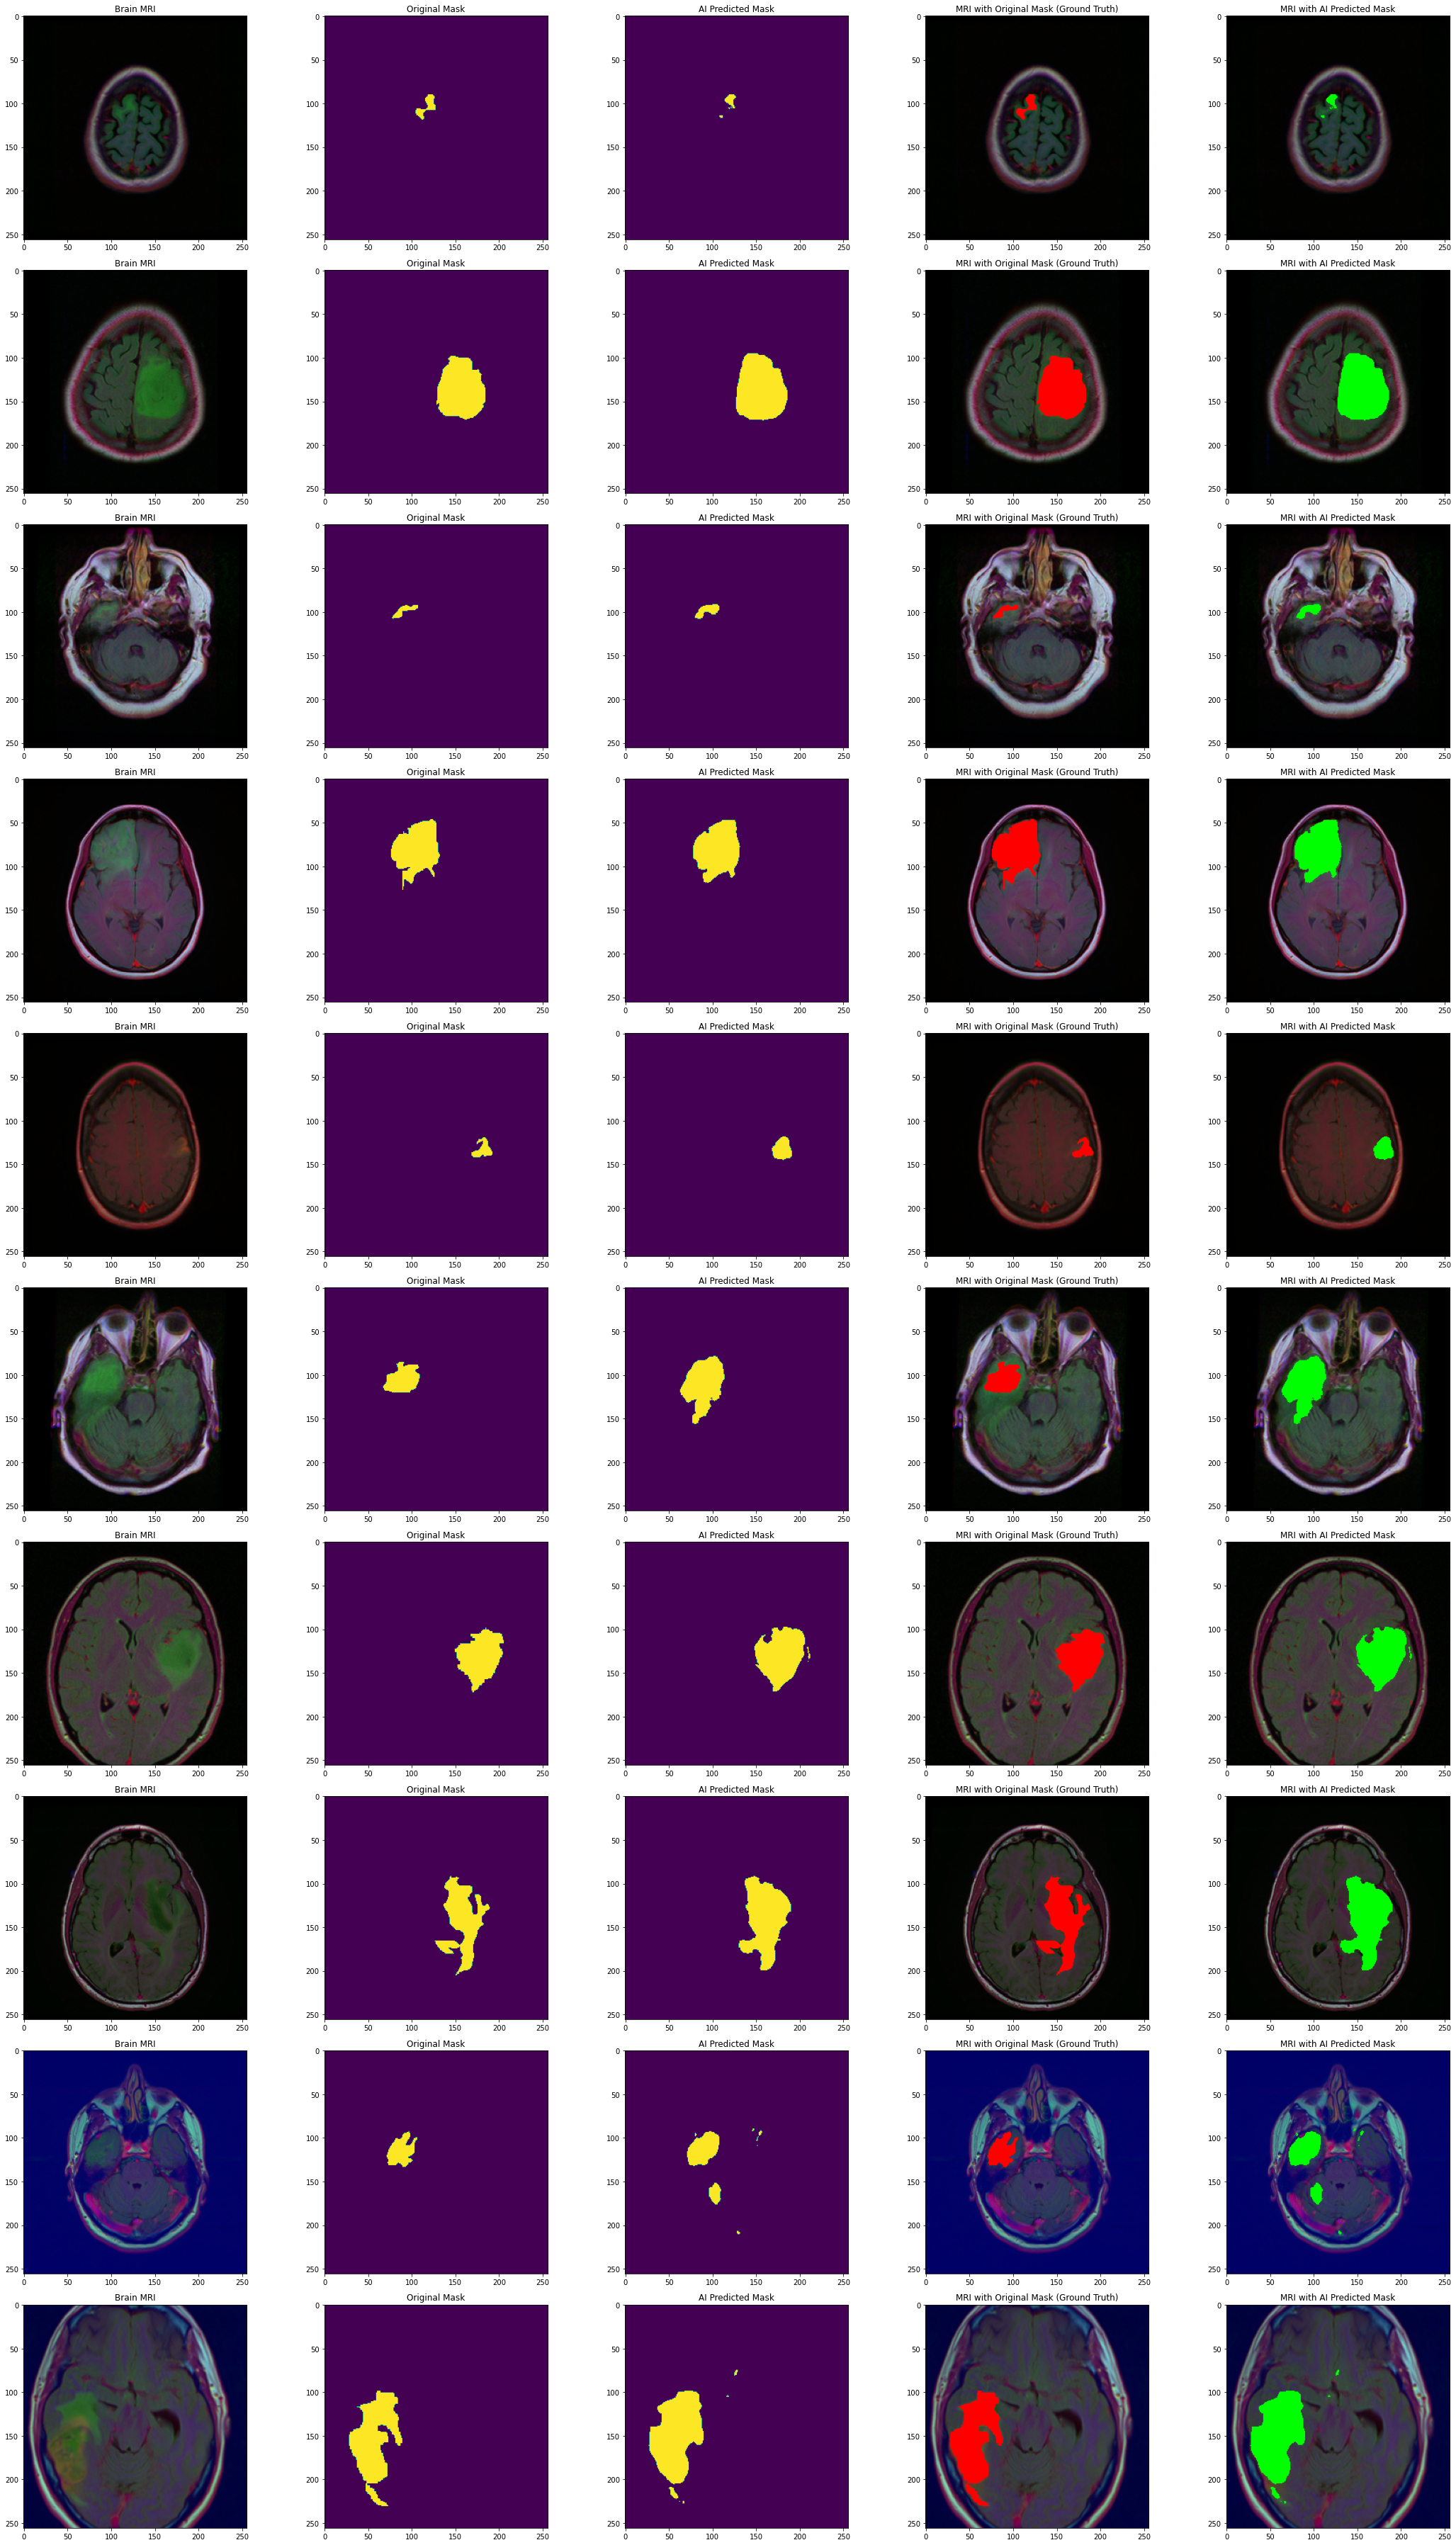

In [62]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

##### Saving model

In [63]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("brain-ResUNet-model.json","w") as json_file:
  json_file.write(model_json)